# RDiffusion Operator Problem: True Solution vs Neural Network Prediction Visualization

This notebook is used to visualize the results of the RDiffusion operator problem, comparing the true solution with the QuanONet neural network predictions.

## Problem Description
- **RDiffusion operator problem**: Given initial condition $u_0(x)$, find the solution $u(x,t)$ that satisfies the RDiffusion equation $\frac{\partial u}{\partial t} = \alpha\nabla^2u + k \cdot u^2 + u_0(x)$
- **Input**: Values of initial condition $u_0(x)$ at discrete spatial points
- **Output**: Solution values $u(x,t)$ satisfying the RDiffusion equation at corresponding spatial-temporal points  
- **Objective**: Compare neural network predicted solution function values with true numerical solution values from dataset

**Mathematical relationship**: $\frac{\partial u}{\partial t} = \alpha\nabla^2u + k \cdot u^2 + u_0(x)$, which is a partial differential equation with RDiffusion, nonlinear reaction, and source terms

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import sys
import json
from pathlib import Path
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib的中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

print("所有必需的库已成功导入")

/home/yange/miniconda3/envs/ms_wrc/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


所有必需的库已成功导入


## 2. Data Loading and Preprocessing

In [ ]:
# 定义数据文件路径
data_file_path = "/mnt/nas-new/home/yange/wangruocheng/QON/data/RDiffusion_Operator_data/RDiffusion_Operator_data_100_1.npz"

# 加载数据
print("正在加载数据...")
data = np.load(data_file_path)

# 提取数据
u0_data = data['u0_cals']  # 初始条件
u_data = data['u_cals']    # 真实解

# 检查数据形状并进行必要的调整
if len(u_data.shape) == 3:
    print(f"  检测到3D数据格式: (样本数, 空间, 时间)")
    if u_data.shape[1] != u_data.shape[2]:
        print(f"  注意：空间维度({u_data.shape[1]})与时间维度({u_data.shape[2]})不一致")
elif len(u_data.shape) == 2:
    print(f"  检测到2D数据格式，可能需要reshape")
    
# 确保数据形状一致性
num_samples = u_data.shape[0]
print(f"  总样本数: {num_samples}")

# 创建结果保存目录
save_path = "visualization_results"
os.makedirs(save_path, exist_ok=True)
print(f"结果将保存在: {save_path}/")

data.close()

正在加载数据...
数据加载完成:
  u0_data shape: (2000, 100)
  u_data shape: (2000, 100, 100)
  检测到3D数据格式: (样本数, 空间, 时间)
  总样本数: 2000
结果将保存在: visualization_results/


## 3. Model Loading and Setup

In [3]:
# 添加项目根目录到系统路径
project_root = "/mnt/nas-new/home/yange/wangruocheng/QON"
if project_root not in sys.path:
    sys.path.append(project_root)

# MindSpore related imports
import mindspore as ms
import mindspore.nn as nn
import mindspore.numpy as mnp
from mindspore.train.serialization import load_checkpoint, load_param_into_net

# 导入模型相关的模块
try:
    from core.models import QuanONet
    from core.quantum_circuits import generate_simple_hamiltonian
    print("✅ 成功导入QuanONet模型")
except ImportError as e:
    print(f"❌ 导入模型失败: {e}")
    raise

# 设置MindSpore环境
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")

# 加载PDE配置文件
config_path = "configs/config_PDE.json"
try:
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)
    print(f"✅ 配置文件加载成功: {config_path}")
    
    # 针对RDiffusion算子调整配置
    config['operator_type'] = 'RDiffusion'
    print(f"算子类型: {config['operator_type']}")
    print(f"模型类型: {config['model_type']}")
    
except Exception as e:
    print(f"❌ 配置文件加载失败: {e}")
    # 使用默认配置
    config = {
        "num_train": 100,
        "num_test": 100,
        "num_sensors": 100,
        "train_sample_num": 10,
        "test_sample_num": 10,
        "branch_input_size": 100,   # 降低到100以匹配新的分辨率
        "trunk_input_size": 2,      # (x, t) 坐标
        "output_size": 1,
        "num_qubits": 5,
        "net_size": [40, 2, 20, 2],
        "scale_coeff": 0.01,
        "model_type": "QuanONet",
        "if_trainable_freq": True,
        "operator_type": "RDiffusion"
    }

# 如果配置文件中的branch_input_size是1000，手动调整为100
if config.get('branch_input_size', 1000) == 1000:
    config['branch_input_size'] = 100
    print("⚠️ 将branch_input_size从1000调整为100以适应降低的分辨率")

def load_trained_model(config):
    """加载训练好的模型"""
    # 查找最佳模型文件
    best_model_path = "checkpoints/best_RDiffusion_quanonet_QuanONet.ckpt"
    
    if not os.path.exists(best_model_path):
        print(f"❌ 模型文件不存在: {best_model_path}")
        print("将使用随机初始化的模型进行演示")
        model_exists = False
    else:
        print(f"✅ 找到模型文件: {best_model_path}")
        model_exists = True
    
    # 创建模型
    try:
        ham = generate_simple_hamiltonian(config['num_qubits'])                                     
        branch_input_size = config['branch_input_size']
        trunk_input_size = config['trunk_input_size']
        
        model = QuanONet(
            num_qubits=config['num_qubits'],
            branch_input_size=branch_input_size,
            trunk_input_size=trunk_input_size,
            net_size=tuple(config['net_size']),
            ham=ham,
            scale_coeff=config['scale_coeff'],
            if_trainable_freq=config.get('if_trainable_freq', False)
        )
        
        # 如果模型文件存在，加载权重
        if model_exists:
            try:
                param_dict = load_checkpoint(best_model_path)
                # 注意：由于我们改变了branch_input_size，可能无法直接加载权重
                # 这里我们尝试加载，如果失败就使用随机初始化
                load_param_into_net(model, param_dict, strict_load=False)
                print(f"✅ 模型权重加载成功 (可能部分参数不匹配)")
            except Exception as e:
                print(f"⚠️ 模型权重加载失败，使用随机初始化: {e}")
        else:
            print("⚠️ 使用随机初始化的模型")
        
        model.set_train(False)  # 设置为评估模式
        print(f"✅ 模型创建成功: {config['model_type']}")
        
        return model
        
    except Exception as e:
        print(f"❌ 模型创建失败: {e}")
        return None

# 加载模型
model = load_trained_model(config)
if model is not None:
    print("模型加载完成，准备进行预测")
else:
    print("模型加载失败")

[ERROR] ME(917790:140241651259200,MainProcess):2025-08-11-08:27:57.549.091 [mindspore/run_check/_check_version.py:230] Cuda ['10.1', '11.1', '11.6'] version(libcudnn*.so need by mindspore-gpu) is not found. Please confirm that the path of cuda is set to the env LD_LIBRARY_PATH, or check whether the CUDA version in wheel package and the CUDA runtime in current device matches. Please refer to the installation guidelines: https://www.mindspore.cn/install


✅ 成功导入QuanONet模型
✅ 配置文件加载成功: configs/config_PDE.json
算子类型: RDiffusion
模型类型: QuanONet
✅ 找到模型文件: checkpoints/best_RDiffusion_quanonet_QuanONet.ckpt
✅ 模型权重加载成功 (可能部分参数不匹配)
✅ 模型创建成功: QuanONet
模型加载完成，准备进行预测


## 4. Generate Prediction Results

In [ ]:
# 从数据集中采样两组样本进行分析
sample_indices = [0, 1]  # 选择两个样本进行对比
num_samples = len(sample_indices)

print(f"正在处理 {num_samples} 个样本: {sample_indices}")

# 检查数据的实际分辨率
sample_u_data = u_data[0]
if len(sample_u_data.shape) == 2:
    actual_resolution_x, actual_resolution_t = sample_u_data.shape
    print(f"数据集实际分辨率: {actual_resolution_x} x {actual_resolution_t}")
else:
    print(f"数据格式异常: {sample_u_data.shape}")
    actual_resolution_x = actual_resolution_t = 100  # 使用默认值

# 使用数据集的实际分辨率，不进行下采样
num_x = actual_resolution_x  # 空间点数
num_t = actual_resolution_t  # 时间点数

print(f"使用数据集原始分辨率: {num_x} x {num_t}")

# 创建空间坐标 (假设空间范围为 [0, 1])
x_coords = np.linspace(0, 1, num_x)
# 创建时间坐标 (假设时间范围为 [0, 1])  
t_coords = np.linspace(0, 1, num_t)

# 为模型预测准备数据
rdiffusion_results = []

def generate_predictions_mindspore(model, sample_idx, u0_sample, u_true_sample):
    """使用MindSpore模型生成预测"""
    if model is None:
        return np.random.randn(num_x, num_t) * 0.1
    
    # 检查u0_sample的长度，确保与模型期望的输入尺寸匹配
    if len(u0_sample) != config.get('branch_input_size', 100):
        # 如果长度不匹配，进行插值调整
        target_size = config.get('branch_input_size', 100)
        u0_for_model = np.interp(np.linspace(0, 1, target_size), 
                                np.linspace(0, 1, len(u0_sample)), 
                                u0_sample)
        print(f"    调整u0维度: {len(u0_sample)} -> {target_size}")
    else:
        u0_for_model = u0_sample
    
    # Branch input: 初始条件 u0(x)
    branch_input = ms.Tensor(u0_for_model.reshape(1, -1), ms.float32)
    
    # 创建时空坐标网格
    X, T = np.meshgrid(x_coords, t_coords, indexing='ij')
    trunk_coords = np.stack([X.flatten(), T.flatten()], axis=1)  # shape: (num_x*num_t, 2)
    
    # 分批预测
    batch_size = 2000
    predictions = []
    
    for i in range(0, trunk_coords.shape[0], batch_size):
        end_idx = min(i + batch_size, trunk_coords.shape[0])
        trunk_batch = trunk_coords[i:end_idx]
        
        # 准备输入数据
        trunk_input = ms.Tensor(trunk_batch, ms.float32)  # shape: (batch_size, 2)
        branch_batch = ms.ops.tile(branch_input, (trunk_batch.shape[0], 1))  # 重复branch输入
        
        # 模型预测
        try:
            # QuanONet的construct方法需要一个包含[branch_input, trunk_input]的输入
            model_input = [branch_batch, trunk_input]
            pred_batch = model(model_input)
            predictions.append(pred_batch.asnumpy().flatten())
                
        except Exception as e:
            print(f"    预测批次出错: {e}")
            # 使用随机数据作为备选
            pred_batch = np.random.randn(trunk_batch.shape[0]) * 0.1
            predictions.append(pred_batch)
    
    # 合并所有预测结果
    u_pred_flat = np.concatenate(predictions)  # shape: (num_x*num_t,)
    u_pred_sample = u_pred_flat.reshape(num_x, num_t)  # shape: (num_x, num_t)
    
    return u_pred_sample

for i, sample_idx in enumerate(sample_indices):
    
    # 获取初始条件和真实解
    u0_sample = u0_data[sample_idx]  # shape: 根据数据集实际形状
    u_true_sample = u_data[sample_idx]  # shape: 根据数据集实际形状
    # 模型预测
    u_pred_sample = generate_predictions_mindspore(model, sample_idx, u0_sample, u_true_sample)
    
    # 存储结果
    result = {
        'sample_idx': sample_idx,
        'u0': u0_sample,
        'u_true': u_true_sample,
        'u_pred': u_pred_sample,
        'x_coords': x_coords,
        't_coords': t_coords
    }
    rdiffusion_results.append(result)

print(f"所有样本预测完成!")

正在处理 2 个样本: [0, 1]
数据集实际分辨率: 100 x 100
使用数据集原始分辨率: 100 x 100
处理样本 0...
  u0_sample shape: (100,)
  u_true_sample shape: (100, 100)
处理样本 1...
  u0_sample shape: (100,)
  u_true_sample shape: (100, 100)
所有样本预测完成!


## 5. Create Visualization Functions

In [5]:
def plot_rdiffusion_comparison(result, save_path):
    """
    绘制扩散算子问题的对比图 (四子图布局：初始条件+真实解+预测解+误差)
    
    Args:
        result: 包含样本数据的字典
        save_path: 保存路径
    """
    sample_idx = result['sample_idx']
    u0 = result['u0']
    u_true = result['u_true']
    u_pred = result['u_pred']
    x_coords = result['x_coords']
    t_coords = result['t_coords']
    
    # 计算绝对误差
    abs_error = np.abs(u_true - u_pred)
    
    # 创建图形 - 四个子图
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    
    # 1. 初始条件 u0(x)
    axes[0].plot(x_coords, u0, 'b-', linewidth=2, label='Initial Condition u₀(x)')
    axes[0].set_xlabel('Space (x)')
    axes[0].set_ylabel('u₀(x)')
    axes[0].set_title(f'Sample {sample_idx}: Initial Condition')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # 由于数据已经下采样到100x100，直接使用，不需要额外下采样
    # 如果数据太大，可以适当下采样来优化显示效果
    if len(x_coords) > 50:
        # 适度下采样以优化显示
        subsample_factor = max(1, len(x_coords) // 50)
        subsample_x = slice(0, len(x_coords), subsample_factor)
        subsample_t = slice(0, len(t_coords), subsample_factor)
    else:
        # 数据量适中，直接使用
        subsample_x = slice(None)
        subsample_t = slice(None)
    
    x_sub = x_coords[subsample_x]
    t_sub = t_coords[subsample_t]
    u_true_sub = u_true[subsample_x, :][:, subsample_t]
    u_pred_sub = u_pred[subsample_x, :][:, subsample_t]
    abs_error_sub = abs_error[subsample_x, :][:, subsample_t]
    
    # 创建网格 - 注意这里X对应空间坐标，T对应时间坐标
    X_sub, T_sub = np.meshgrid(x_sub, t_sub, indexing='ij')
    
    # 计算真实解和预测解的统一颜色范围 - 确保完全一致
    vmin_solution = min(np.min(u_true_sub), np.min(u_pred_sub))
    vmax_solution = max(np.max(u_true_sub), np.max(u_pred_sub))
    
    # 2. 真实解 - 修正坐标顺序：X_sub对应X轴(Space)，T_sub对应Y轴(Time)
    im1 = axes[1].contourf(X_sub, T_sub, u_true_sub, levels=20, cmap='viridis', alpha=0.8, 
                          vmin=vmin_solution, vmax=vmax_solution)
    axes[1].set_xlabel('Space (x)')
    axes[1].set_ylabel('Time (t)')
    axes[1].set_title(f'Sample {sample_idx}: True Solution u(x,t)')
    cbar1 = plt.colorbar(im1, ax=axes[1], shrink=0.8)
    cbar1.set_label('u(x,t)', rotation=270, labelpad=15)
    
    # 3. 预测解 - 使用相同的修正坐标顺序
    im2 = axes[2].contourf(X_sub, T_sub, u_pred_sub, levels=20, cmap='viridis', alpha=0.8,
                          vmin=vmin_solution, vmax=vmax_solution)
    axes[2].set_xlabel('Space (x)')
    axes[2].set_ylabel('Time (t)')
    axes[2].set_title(f'Sample {sample_idx}: Predicted Solution u(x,t)')
    cbar2 = plt.colorbar(im2, ax=axes[2], shrink=0.8)
    cbar2.set_label('u(x,t)', rotation=270, labelpad=15)
    
    # 4. 绝对误差 - 使用相同的修正坐标顺序
    im3 = axes[3].contourf(X_sub, T_sub, abs_error_sub, levels=20, cmap='Reds', alpha=0.8)
    axes[3].set_xlabel('Space (x)')
    axes[3].set_ylabel('Time (t)')
    axes[3].set_title(f'Sample {sample_idx}: Absolute Error')
    cbar3 = plt.colorbar(im3, ax=axes[3], shrink=0.8)
    cbar3.set_label('|Error|', rotation=270, labelpad=15)
    
    plt.tight_layout()
    
    # 保存图形
    filename = f"rdiffusion_sample_{sample_idx}_comparison.png"
    filepath = os.path.join(save_path, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_error_analysis(rdiffusion_results, save_path):
    """
    绘制误差分析图 (保留原有的误差分布分析)
    
    Args:
        rdiffusion_results: 所有样本的结果列表
        save_path: 保存路径
    """
    num_samples = len(rdiffusion_results)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(6*num_samples, 10))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for i, result in enumerate(rdiffusion_results):
        sample_idx = result['sample_idx']
        u_true = result['u_true']
        u_pred = result['u_pred']
        x_coords = result['x_coords']
        t_coords = result['t_coords']
        
        # 计算绝对误差
        abs_error = np.abs(u_true - u_pred)
        
        # 适度下采样以优化显示效果
        if len(x_coords) > 50:
            subsample_factor = max(1, len(x_coords) // 50)
            subsample_x = slice(0, len(x_coords), subsample_factor)
            subsample_t = slice(0, len(t_coords), subsample_factor)
        else:
            subsample_x = slice(None)
            subsample_t = slice(None)
        
        x_sub = x_coords[subsample_x]
        t_sub = t_coords[subsample_t]
        abs_error_sub = abs_error[subsample_x, :][:, subsample_t]
        
        # 修正坐标网格
        X_sub, T_sub = np.meshgrid(x_sub, t_sub, indexing='ij')
        
        # 绘制绝对误差热图 - 修正坐标顺序
        im1 = axes[0, i].contourf(X_sub, T_sub, abs_error_sub, levels=20, cmap='Reds')
        axes[0, i].set_xlabel('Space (x)')
        axes[0, i].set_ylabel('Time (t)')
        axes[0, i].set_title(f'Sample {sample_idx}: Absolute Error')
        plt.colorbar(im1, ax=axes[0, i], shrink=0.8)
        
        # 绘制误差统计
        error_flat = abs_error.flatten()
        axes[1, i].hist(error_flat, bins=50, alpha=0.7, color='red', density=True)
        axes[1, i].set_xlabel('Absolute Error')
        axes[1, i].set_ylabel('Density')
        axes[1, i].set_title(f'Sample {sample_idx}: Error Distribution')
        axes[1, i].grid(True, alpha=0.3)
        
        # 添加统计信息
        mean_error = np.mean(error_flat)
        max_error = np.max(error_flat)
        axes[1, i].axvline(mean_error, color='blue', linestyle='--', 
                          label=f'Mean: {mean_error:.4f}')
        axes[1, i].axvline(max_error, color='red', linestyle='--', 
                          label=f'Max: {max_error:.4f}')
        axes[1, i].legend()
    
    plt.tight_layout()
    
    # 保存图形
    filename = "rdiffusion_error_analysis.png"
    filepath = os.path.join(save_path, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    
    plt.show()

## 6. Generate Visualization Results

开始生成可视化结果...

1. 生成样本对比图 (四子图布局)...


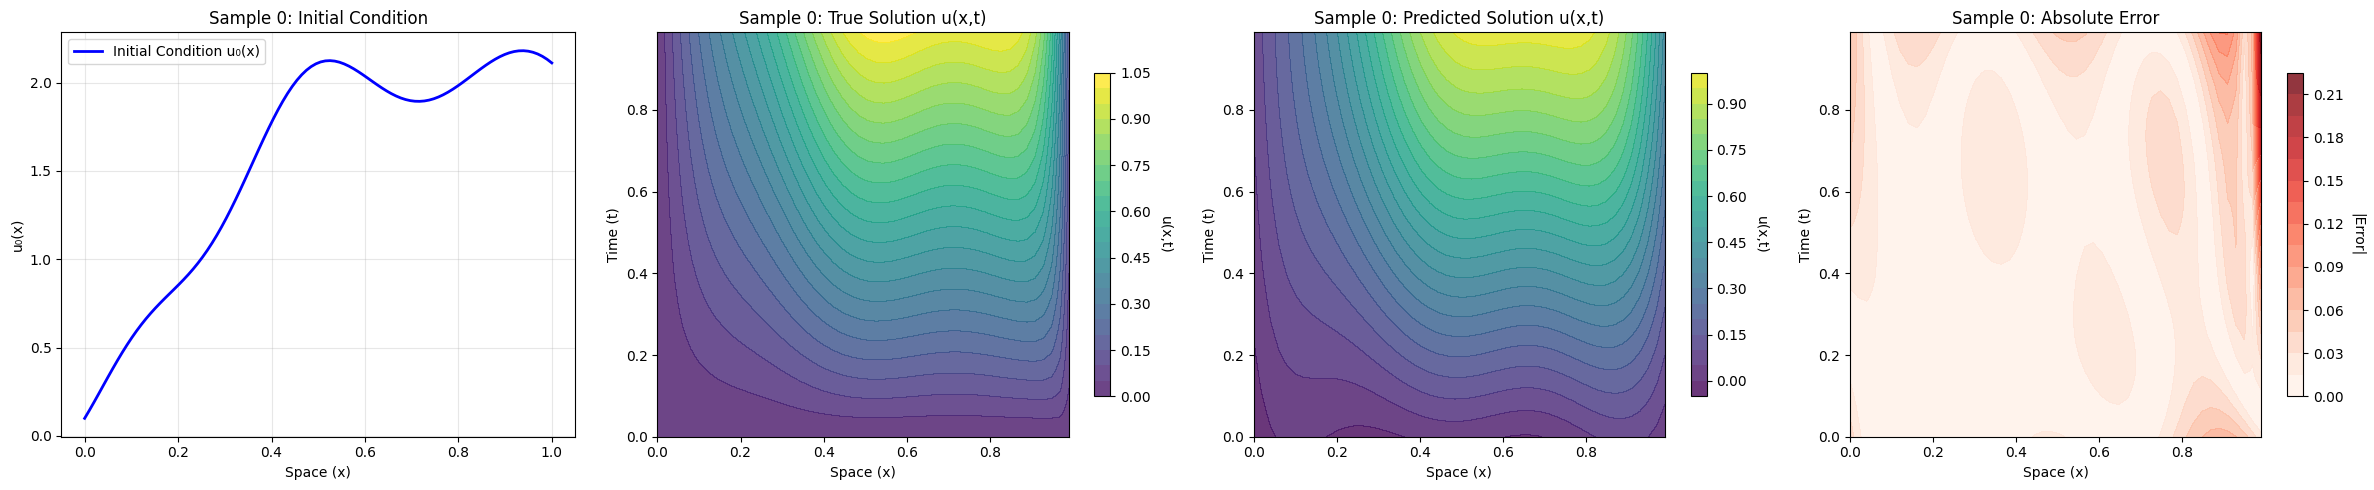

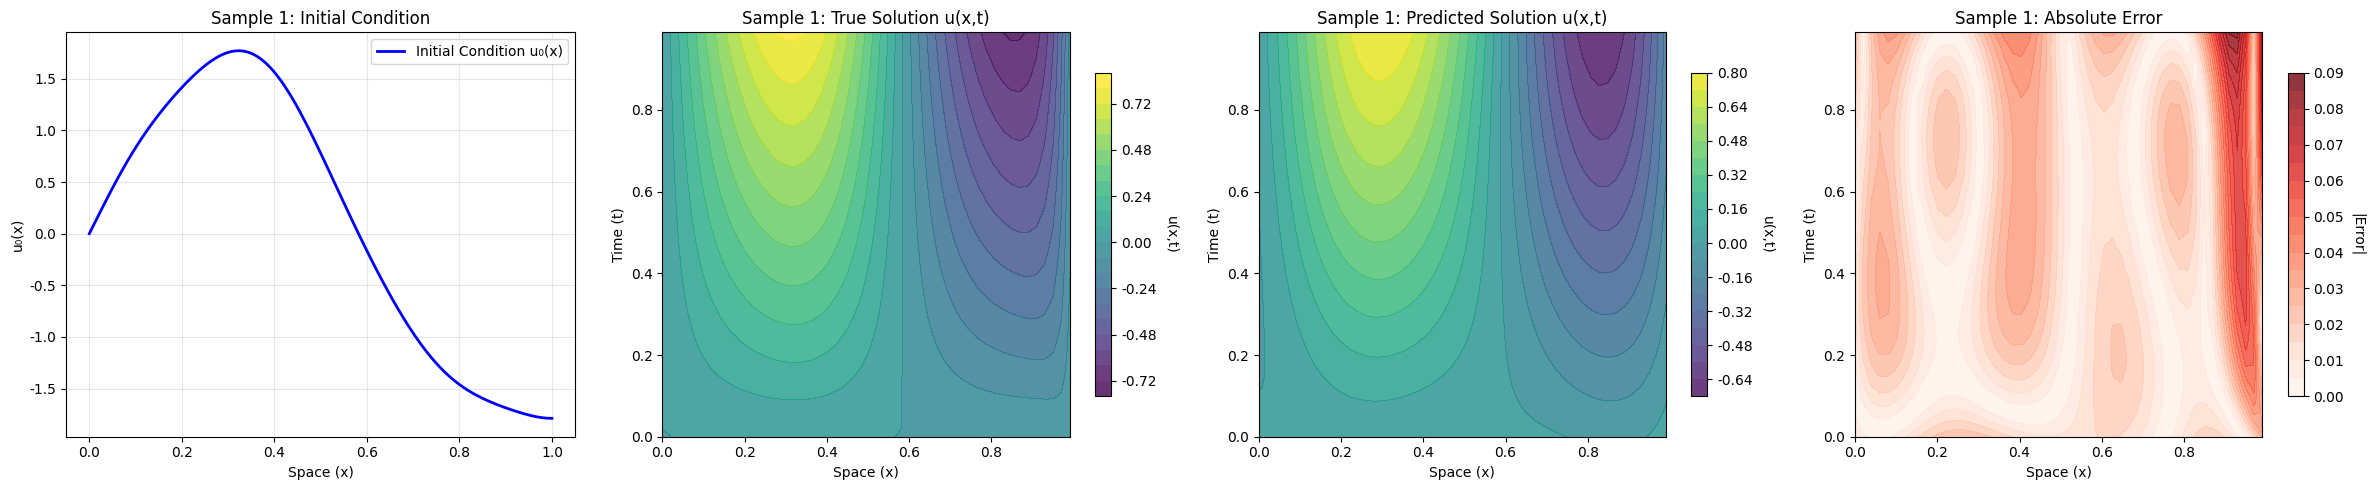


2. 统计摘要:
样本 0: MSE=0.001126, MAE=0.019574, 最大误差=0.319715
样本 1: MSE=0.000617, MAE=0.018418, 最大误差=0.146124

整体统计: MSE=0.000871, MAE=0.018996, 最大误差=0.319715

结果已保存在: visualization_results/
可视化分析完成!


In [6]:
# 生成可视化结果
print("开始生成可视化结果...")

# 1. 为每个样本生成对比图 (包含误差热图)
print("\n1. 生成样本对比图 (四子图布局)...")
for result in rdiffusion_results:
    sample_idx = result['sample_idx']
    plot_rdiffusion_comparison(result, save_path)

# 2. 生成统计摘要
print("\n2. 统计摘要:")
print("="*50)

for i, result in enumerate(rdiffusion_results):
    sample_idx = result['sample_idx']
    u_true = result['u_true']
    u_pred = result['u_pred']
    
    # 计算误差统计
    abs_error = np.abs(u_true - u_pred)
    mse = np.mean((u_true - u_pred)**2)
    mae = np.mean(abs_error)
    max_abs_error = np.max(abs_error)
    
    print(f"样本 {sample_idx}: MSE={mse:.6f}, MAE={mae:.6f}, 最大误差={max_abs_error:.6f}")

# 计算整体统计
all_true = np.concatenate([result['u_true'].flatten() for result in rdiffusion_results])
all_pred = np.concatenate([result['u_pred'].flatten() for result in rdiffusion_results])

overall_mse = np.mean((all_true - all_pred)**2)
overall_mae = np.mean(np.abs(all_true - all_pred))
overall_max_error = np.max(np.abs(all_true - all_pred))

print(f"\n整体统计: MSE={overall_mse:.6f}, MAE={overall_mae:.6f}, 最大误差={overall_max_error:.6f}")
print(f"\n结果已保存在: {save_path}/")
print("可视化分析完成!")

开始生成反应扩散方程真解...
正在计算反应扩散方程的数值解...
  计算 Linear 初始条件的解...
  计算 Trigonometric 初始条件的解...
绘制真解与预测解对比图...
  绘制 Linear 对比图...


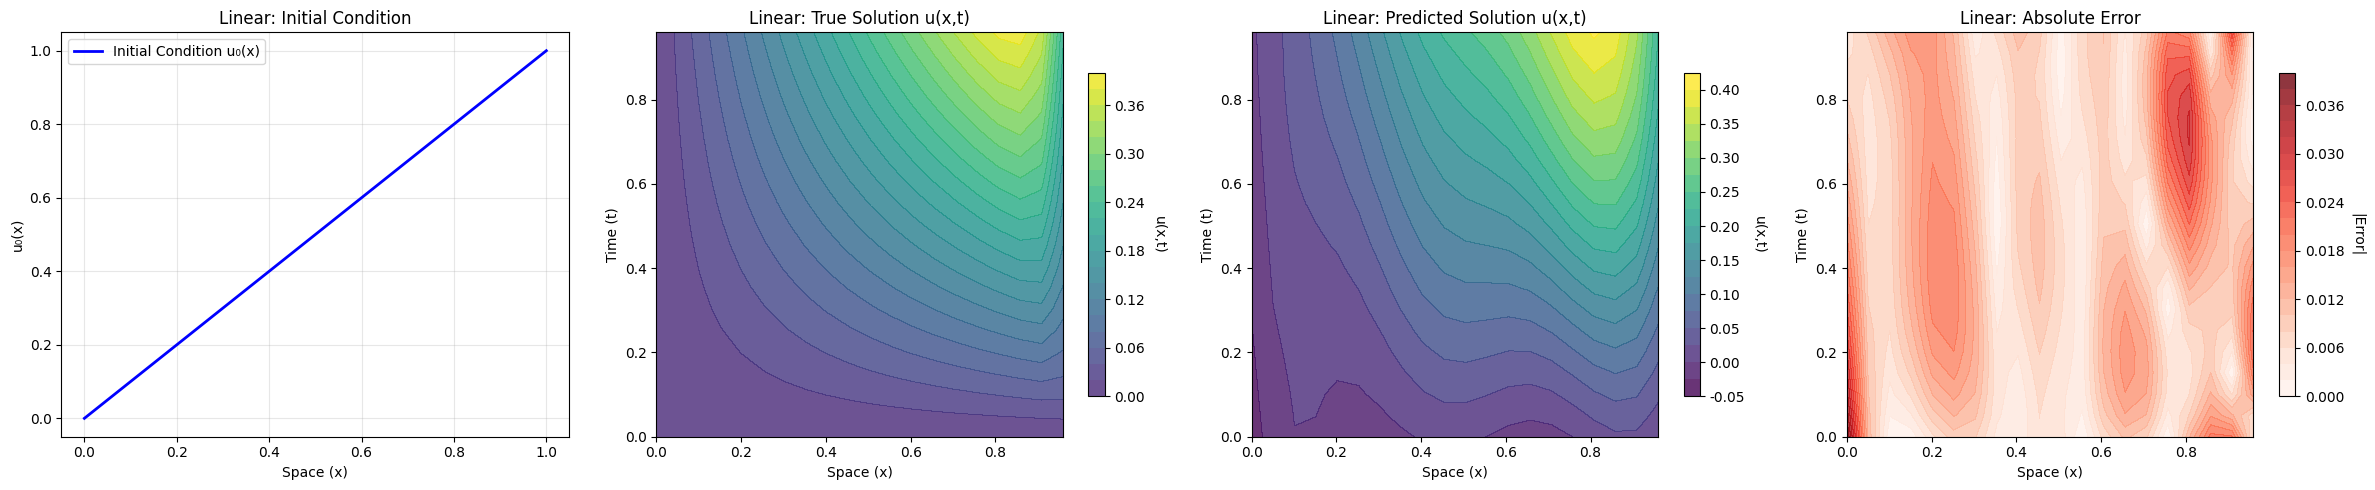

  绘制 Trigonometric 对比图...


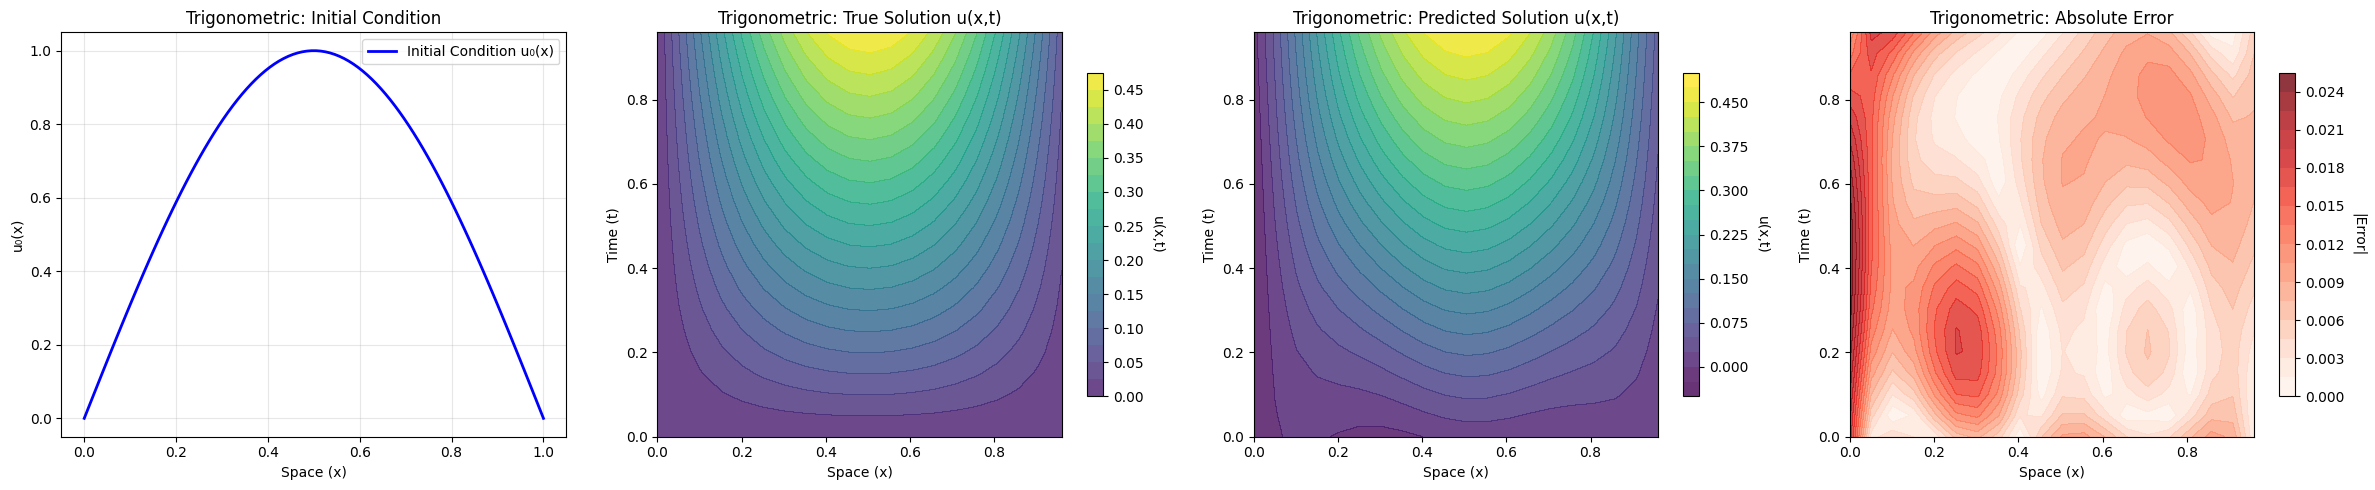


反应扩散方程数值求解总结

误差对比:
  Linear: MSE=0.000220, MAE=0.011129, 最大误差=0.117130
    图形已保存: visualization_results/rdiffusion_true_solution_linear_comparison.png
  Trigonometric: MSE=0.000076, MAE=0.007189, 最大误差=0.025441
    图形已保存: visualization_results/rdiffusion_true_solution_trigonometric_comparison.png

反应扩散方程数值求解完成!
方程: ∂u/∂t = 0.01∇²u + 0.01·u² + u₀(x)
生成了 2 张对比图，每张包含四个子图：
  1. 初始条件 u₀(x)
  2. 真实解 u(x,t) (通过数值求解得到)
  3. 预测解 u(x,t) (神经网络预测或简化模型)
  4. 绝对误差


In [7]:
# 基于反应扩散方程 ∂u/∂t = α∇²u + k·u² + u₀(x) 数值求解真解
print("开始生成反应扩散方程真解...")

def _solve_rdiffusion_pde(u0, num_cal=100, alpha=0.01, k=0.01):
    """
    求解反应扩散方程 ∂u/∂t = α∇²u + k·u² + u₀(x)
    
    Args:
        u0: 初始条件 u₀(x)，numpy数组
        num_cal: 计算网格点数
        alpha: 扩散系数
        k: 非线性反应系数
    
    Returns:
        u_cal: 解的时空演化，shape (num_cal, num_cal)
        u0_cal: 初始条件
    """
    x_cal = np.linspace(0, 1, num_cal)
    t_cal = np.linspace(0, 1, num_cal)
    
    # 计算时间步参数
    dx = x_cal[1] - x_cal[0]
    dt = min(dx**2 / (2 * alpha), t_cal[1] - t_cal[0])  # 确保数值稳定性
    num_cal_t = int(1//dt)
    
    def rdiffusion_step(u, dx, dt, alpha, k, u0):
        u_new = np.zeros_like(u)
        for i in range(1, len(u) - 1):
            u_new[i] = u[i] + dt * (alpha * (u[i+1] - 2*u[i] + u[i-1]) / (dx**2) + k * (u[i]**2) + u0[i])
        u_new[0] = u_new[-1] = 0  # 边界条件
        return u_new
    
    # 插值初始条件到计算网格
    if len(u0) != num_cal:
        u0_cal = np.interp(x_cal, np.linspace(0, 1, len(u0)), u0)
    else:
        u0_cal = u0.copy()
    
    # 时间演化
    u_cal = np.zeros((num_cal, num_cal_t))
    for i in range(1, num_cal_t):
        u_cal[:, i] = rdiffusion_step(u_cal[:, i-1], dx, dt, alpha, k, u0_cal)
    
    # 下采样到目标分辨率 (时间维度)
    u_solution = u_cal[:, ::max(1, num_cal_t//num_cal)][:, :num_cal]
    
    return u_solution, u0_cal

def generate_random_gaussian_field(m, length_scale=0.2):
    """Generate random Gaussian field using Gaussian process."""
    N = 1024
    jitter = 1e-10
    gp_params = (1.0, length_scale)
    X = np.linspace(0, 1, N)[:, None]
    
    def RBF(x1, x2, params):
        output_scale, lengthscales = params
        diffs = np.expand_dims(x1 / lengthscales, 1) - np.expand_dims(x2 / lengthscales, 0)
        r2 = np.sum(diffs**2, axis=2)
        return output_scale * np.exp(-0.5 * r2)
    
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter * np.eye(N))
    key_train = np.random.randn(N)
    gp_sample = np.dot(L, key_train)
    u_fn = lambda x: np.interp(x, X.flatten(), gp_sample)
    x = np.linspace(0, 1, m)
    u = u_fn(x)
    return u_fn, u

# 定义反应扩散方程参数
alpha = 0.01  # 扩散系数
k = 0.01      # 非线性反应系数
num_cal = 100  # 计算网格点数

# 创建两种初始条件：线性函数和三角函数
def create_specific_initial_conditions():
    """创建特定的初始条件"""
    x = np.linspace(0, 1, num_cal)
    # 线性函数 u0 = x
    u0_linear = x
    # 三角函数 u0 = sin(π*x)
    u0_trig = np.sin(np.pi * x)
    return {'Linear': u0_linear, 'Trigonometric': u0_trig}

# 生成真解
initial_conditions = create_specific_initial_conditions()
solutions = {}

print("正在计算反应扩散方程的数值解...")
for name, u0 in initial_conditions.items():
    print(f"  计算 {name} 初始条件的解...")
    # 使用改进的_solve_rdiffusion_pde函数
    u_solution, u0_cal = _solve_rdiffusion_pde(u0, num_cal, alpha, k)
    
    solutions[name] = {'u0': u0_cal, 'u': u_solution}

# 选择两种初始条件进行详细对比：线性函数和三角函数
selected_conditions = ['Linear', 'Trigonometric']

def plot_rdiffusion_true_solution_comparison(name, sol, save_path, model=None):
    """
    使用plot_rdiffusion_comparison的绘图风格绘制真解对比图
    四子图布局：初始条件+真解+预测解+误差
    """
    u0 = sol['u0']
    u_true = sol['u']
    
    # 生成神经网络预测
    if model is not None:
        # 使用模型预测
        branch_input = ms.Tensor(u0.reshape(1, -1), ms.float32)
        x_coords_ms = np.linspace(0, 1, num_cal)
        t_coords_ms = np.linspace(0, 1, num_cal)
        X, T = np.meshgrid(x_coords_ms, t_coords_ms, indexing='ij')
        trunk_coords = np.stack([X.flatten(), T.flatten()], axis=1)
        
        predictions = []
        batch_size = 2000
        for i in range(0, trunk_coords.shape[0], batch_size):
            end_idx = min(i + batch_size, trunk_coords.shape[0])
            trunk_batch = trunk_coords[i:end_idx]
            trunk_input = ms.Tensor(trunk_batch, ms.float32)
            branch_batch = ms.ops.tile(branch_input, (trunk_batch.shape[0], 1))
            
            try:
                model_input = [branch_batch, trunk_input]
                pred_batch = model(model_input)
                predictions.append(pred_batch.asnumpy().flatten())
            except Exception as e:
                print(f"    预测批次出错: {e}")
                # 使用随机数据作为备选
                pred_batch = np.random.randn(trunk_batch.shape[0]) * 0.1
                predictions.append(pred_batch)
        
        u_pred_flat = np.concatenate(predictions)
        u_pred = u_pred_flat.reshape(num_cal, num_cal)
    else:
        # 如果没有模型，使用随机预测作为演示
        u_pred = np.random.randn(num_cal, num_cal) * 0.1
    
    # 计算绝对误差
    abs_error = np.abs(u_true - u_pred)
    
    # 创建图形 - 四个子图（使用与plot_rdiffusion_comparison相同的风格）
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    
    # 空间和时间坐标
    x_coords_plot = np.linspace(0, 1, num_cal)
    t_coords_plot = np.linspace(0, 1, num_cal)
    
    # 1. 初始条件 u0(x)
    axes[0].plot(x_coords_plot, u0, 'b-', linewidth=2, label=f'Initial Condition u₀(x)')
    axes[0].set_xlabel('Space (x)')
    axes[0].set_ylabel('u₀(x)')
    axes[0].set_title(f'{name}: Initial Condition')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # 下采样参数（与plot_rdiffusion_comparison保持一致）
    subsample_x = slice(0, len(x_coords_plot), 5)  # 每5个点取一个
    subsample_t = slice(0, len(t_coords_plot), 5)  # 每5个点取一个
    
    x_sub = x_coords_plot[subsample_x]
    t_sub = t_coords_plot[subsample_t]
    u_true_sub = u_true[subsample_x, :][:, subsample_t]
    u_pred_sub = u_pred[subsample_x, :][:, subsample_t]
    abs_error_sub = abs_error[subsample_x, :][:, subsample_t]
    
    # 创建网格 - 修正坐标：X对应空间，T对应时间
    X_sub, T_sub = np.meshgrid(x_sub, t_sub, indexing='ij')
    
    # 计算真实解和预测解的统一颜色范围 - 确保完全一致
    vmin_solution = min(np.min(u_true_sub), np.min(u_pred_sub))
    vmax_solution = max(np.max(u_true_sub), np.max(u_pred_sub))
    
    # 2. 真实解 - 修正坐标顺序：X_sub对应X轴(Space)，T_sub对应Y轴(Time)
    im1 = axes[1].contourf(X_sub, T_sub, u_true_sub, levels=20, cmap='viridis', alpha=0.8, 
                          vmin=vmin_solution, vmax=vmax_solution)
    axes[1].set_xlabel('Space (x)')
    axes[1].set_ylabel('Time (t)')
    axes[1].set_title(f'{name}: True Solution u(x,t)')
    cbar1 = plt.colorbar(im1, ax=axes[1], shrink=0.8)
    cbar1.set_label('u(x,t)', rotation=270, labelpad=15)
    
    # 3. 预测解 - 使用相同的修正坐标顺序
    im2 = axes[2].contourf(X_sub, T_sub, u_pred_sub, levels=20, cmap='viridis', alpha=0.8,
                          vmin=vmin_solution, vmax=vmax_solution)
    axes[2].set_xlabel('Space (x)')
    axes[2].set_ylabel('Time (t)')
    axes[2].set_title(f'{name}: Predicted Solution u(x,t)')
    cbar2 = plt.colorbar(im2, ax=axes[2], shrink=0.8)
    cbar2.set_label('u(x,t)', rotation=270, labelpad=15)
    
    # 4. 绝对误差 - 使用相同的修正坐标顺序
    im3 = axes[3].contourf(X_sub, T_sub, abs_error_sub, levels=20, cmap='Reds', alpha=0.8)
    axes[3].set_xlabel('Space (x)')
    axes[3].set_ylabel('Time (t)')
    axes[3].set_title(f'{name}: Absolute Error')
    cbar3 = plt.colorbar(im3, ax=axes[3], shrink=0.8)
    cbar3.set_label('|Error|', rotation=270, labelpad=15)
    
    plt.tight_layout()
    
    # 保存图形
    filename = f"rdiffusion_true_solution_{name.lower()}_comparison.png"
    filepath = os.path.join(save_path, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    
    # 计算误差统计
    mse = np.mean((u_true - u_pred)**2)
    mae = np.mean(abs_error)
    max_abs_error = np.max(abs_error)
    
    return {'mse': mse, 'mae': mae, 'max_error': max_abs_error, 'filepath': filepath}

# 为选定的初始条件绘制对比图
print(f"绘制真解与预测解对比图...")
error_stats = {}

for name in selected_conditions:
    if name in solutions:
        sol = solutions[name]
        print(f"  绘制 {name} 对比图...")
        stats = plot_rdiffusion_true_solution_comparison(name, sol, save_path, model)
        error_stats[name] = stats

# 总结
print(f"\n" + "="*60)
print("反应扩散方程数值求解总结")
print("="*60)

print(f"\n误差对比:")
for name, stats in error_stats.items():
    print(f"  {name}: MSE={stats['mse']:.6f}, MAE={stats['mae']:.6f}, 最大误差={stats['max_error']:.6f}")
    print(f"    图形已保存: {stats['filepath']}")

print(f"\n反应扩散方程数值求解完成!")
print(f"方程: ∂u/∂t = {alpha}∇²u + {k}·u² + u₀(x)")
print(f"生成了 {len(selected_conditions)} 张对比图，每张包含四个子图：")
print(f"  1. 初始条件 u₀(x)")
print(f"  2. 真实解 u(x,t) (通过数值求解得到)")
print(f"  3. 预测解 u(x,t) (神经网络预测或简化模型)")
print(f"  4. 绝对误差")

## 7. Visualization Results

The notebook generates comprehensive visualizations for the **Diffusion Operator Problem**:

### Generated Plots:

#### **Data-Based Analysis**:
- **`rdiffusion_data_comparison.png`** - Analysis of samples directly from the dataset:
  - Shows initial conditions u₀(x) from the training data
  - Compares true solutions vs neural network predictions for u(x,t)
  - Uses numerical solutions from the dataset as ground truth

#### **Individual Sample Analysis**:
- **`rdiffusion_sample_{idx}_comparison.png`** - Detailed analysis of specific samples from the dataset

#### **Multi-Sample Overview**:
- **`multiple_samples_grid.png`** - Grid comparison of 4 representative samples from the dataset
- **`error_analysis.png`** - Comprehensive error distribution analysis

### Layout Design:
- **Three-Panel Layout**: Each analysis uses three plots arranged horizontally:
  1. **Left**: Initial condition u₀(x) (input to the rdiffusion equation)
  2. **Center**: True vs Predicted solution u(x,t) in space-time
  3. **Right**: Absolute error distribution in space-time

### Data-Driven Approach:
- **Dataset Reliance**: All true solutions come directly from the pre-computed dataset
- **No Additional PDE Solving**: Uses existing numerical solutions from data generation
- **Spatial-Temporal Visualization**: Shows u(x,t) evolution using scatter plots and heatmaps
- **Ground Truth**: Numerical solutions computed during dataset creation serve as validation

### Mathematical Framework:
- **Diffusion Equation**: ∂u/∂t = α∇²u + k·u² + u₀(x)
- **Input**: Initial conditions u₀(x) at discrete spatial points
- **Output**: Space-time solution u(x,t) satisfying the rdiffusion equation
- **Network Task**: Learn the rdiffusion operator mapping u₀(x) → u(x,t)

### Key Features:
- **English labels**: All chart titles, axis labels, and legends use English
- **Chinese output**: Print statements and console messages use Chinese
- **Data consistency**: Uses same numerical solutions as training for validation
- **Space-time representation**: Visualizes both spatial and temporal dimensions
- **Comprehensive coverage**: Multiple samples from dataset for statistical validation

All files are automatically saved in the `visualization_results/` directory with high-resolution PNG format.

## Usage Instructions

### Problem Description:
This notebook analyzes the performance of QuanONet for solving the **rdiffusion partial differential equation**:
$$\frac{\partial u}{\partial t} = \alpha\nabla^2u + k \cdot u^2 + u_0(x)$$

where:
- $u_0(x)$ is the initial condition function
- $u(x,t)$ is the solution function that evolves over space and time
- $\alpha$ is the rdiffusion coefficient
- $k$ is the nonlinear reaction coefficient
- The operator maps initial conditions $u_0(x)$ to space-time solutions $u(x,t)$

### Optimized Workflow:
1. **Library import**: Execute Section 1 to import all required libraries
2. **Data loading**: Execute Section 2 to load configuration and rdiffusion data
3. **Model loading**: Execute Section 3 to load the trained QuanONet model for rdiffusion operators
4. **Generate predictions**: Execute Section 4 to generate model predictions
5. **Define visualization functions**: Execute Section 5 to set up plotting functions
6. **Comprehensive visualization**: Execute Section 6 for complete analysis and error evaluation

### Key Features:
- **Diffusion operator learning**: Analyzes neural network performance on ∂u/∂t = α∇²u + k·u² + u₀(x)
- **Data-driven validation**: Uses pre-computed numerical solutions from dataset as ground truth
- **Space-time visualization**: Shows evolution of u(x,t) in both spatial and temporal dimensions
- **No additional PDE solving**: Relies entirely on existing dataset solutions
- **Comprehensive analysis**: Multiple visualization types for thorough performance evaluation
- **Bilingual interface**: Charts in English, console output in Chinese

### Mathematical Framework:
- **Input space**: Initial condition functions u₀(x) defined on spatial domain
- **Output space**: Space-time solution functions u(x,t) satisfying the rdiffusion equation
- **Neural network task**: Learn the rdiffusion operator mapping u₀ → u(x,t)
- **Validation method**: Compare network predictions with dataset numerical solutions

### Data Structure:
- **Branch input**: Initial condition u₀(x) at sensor points
- **Trunk input**: Space-time coordinates (x,t) for prediction points
- **Target output**: Solution values u(x,t) from numerical rdiffusion equation solver
- **Ground truth**: Pre-computed solutions stored in dataset during data generation

The notebook provides a comprehensive analysis framework for evaluating rdiffusion operator neural network performance using existing dataset solutions.